# Ann Arbor Only Supervised models

## General Imports

In [1]:
import os
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
import altair as alt
from sklearn.model_selection import cross_val_score
from skopt.space import Integer
from skopt.space import Real
from skopt.utils import use_named_args
import numpy as np
from skopt import gp_minimize
from skopt.plots import plot_convergence
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from datetime import date, timedelta
from sktime.performance_metrics.forecasting import mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.set_option('display.max_columns', None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
#pip install sktime

### Now our target will be the '-24hr~temp_KARB0' column, and our features to use in our first prediction model will be all of the measurements at station "KARB0" 24 hours prior to our target.
This cell will run 5 fold cross-validate on our 3 chosen regression models (Extra Trees Regressor, Lasso Regressor, and Tweedie Regressor). This will show how the average accuracy scores compare across these models on this data set.

### Examine the feature importances in the best performing model (Extra Trees Regressor)

## Same general structure/models, now including a longer historical Ann Arbor dataset with some engineered features 
### Get historical dataset from pickle file

In [5]:
ROOT_DIR = os.path.realpath(os.path.join(os.getcwd(), '..'))
aa_pkl_loc = os.path.join(ROOT_DIR, 'data','data','aa_historical.pkl')
df = pd.read_pickle(aa_pkl_loc)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 147192 entries, 2006-01-01 00:00:00 to 2022-10-16 23:00:00
Data columns (total 43 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   temp          146178 non-null  float64       
 1   dwpt          145961 non-null  float64       
 2   rhum          145961 non-null  float64       
 3   prcp          133782 non-null  float64       
 4   snow          0 non-null       float64       
 5   wdir          123067 non-null  float64       
 6   wspd          145776 non-null  float64       
 7   wpgt          0 non-null       float64       
 8   pres          142312 non-null  float64       
 9   tsun          0 non-null       float64       
 10  coco          6926 non-null    float64       
 11  Year          147192 non-null  datetime64[ns]
 12  DayOfYear     147192 non-null  float64       
 13  Hour          147192 non-null  int64         
 14  HourOfYear    147192 non-null  flo

### Basic cleaning procedures

In [6]:
df

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,Year,DayOfYear,Hour,HourOfYear,ATAhr-temp,ATAhr-dwpt,ATAhr-rhum,ATAhr-prcp,ATAhr-wdir_x,ATAhr-wspd,ATAhr-pres,L5Ahr-temp,L5Ahr-dwpt,L5Ahr-rhum,L5Ahr-prcp,ATAhr-wdir_y,L5Ahr-wspd,L5Ahr-pres,ATAday-temp,ATAday-dwpt,ATAday-rhum,ATAday-prcp,ATAday-wdir,ATAday-wspd,ATAday-pres,L5Aday-temp,L5Aday-dwpt,L5Aday-rhum,L5Aday-prcp,L5Aday-wdir,L5Aday-wspd,L5Aday-pres
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,1.0,-1.1,86.0,NaN,NaN,240.0,14.8,NaN,NaN,NaN,NaN,2006-01-01,0.0,1,1.0,-1.033333,-2.033333,93.0000,0.000000,150.000000,12.100000,0.000000,-2.05,-2.50,96.5,0.000,60.000000,9.40,0.000,-2.572776,-6.102156,77.657682,0.09398,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.0,12.152586,1020.086726
2006-01-01 01:00:00,1.1,-0.1,92.0,0.0,NaN,240.0,14.8,NaN,1009.0,NaN,NaN,2006-01-01,0.0,2,2.0,-1.387500,-4.725000,78.6875,0.507143,220.000000,12.093750,1016.846667,-3.90,-7.06,79.4,0.125,173.333333,8.92,1017.325,-2.572776,-6.102156,77.657682,0.09398,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.0,12.152586,1020.086726
2006-01-01 02:00:00,0.6,0.0,96.0,NaN,NaN,250.0,13.0,NaN,1009.5,NaN,NaN,2006-01-01,0.0,3,3.0,-1.793750,-4.925000,79.8125,0.253846,223.076923,11.712500,1016.275000,-4.44,-7.46,80.2,0.375,180.000000,7.78,1015.720,-2.572776,-6.102156,77.657682,0.09398,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.0,12.152586,1020.086726
2006-01-01 03:00:00,1.1,-0.1,92.0,NaN,NaN,250.0,13.0,NaN,1009.6,NaN,NaN,2006-01-01,0.0,4,4.0,-2.081250,-5.062500,80.6875,0.000000,217.333333,14.368750,1016.231250,-4.98,-7.68,82.2,0.000,180.000000,13.02,1015.980,-2.572776,-6.102156,77.657682,0.09398,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.0,12.152586,1020.086726
2006-01-01 04:00:00,1.1,-0.7,88.0,NaN,NaN,250.0,14.8,NaN,1010.5,NaN,NaN,2006-01-01,0.0,5,5.0,-2.500000,-5.243750,82.0000,0.000000,222.000000,15.268750,1016.393750,-5.56,-7.68,85.8,0.000,202.000000,12.54,1016.680,-2.572776,-6.102156,77.657682,0.09398,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.0,12.152586,1020.086726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-16 19:00:00,13.3,3.4,51.0,0.0,NaN,270.0,22.0,NaN,1011.1,NaN,3.0,2022-01-01,288.0,20,6932.0,13.175000,5.593750,61.8125,0.042857,235.714286,18.420000,1013.931250,11.56,3.16,58.4,0.000,270.000000,22.98,1013.780,10.110183,5.411488,74.381201,0.04697,223.482428,13.100263,1014.300000,9.480000,4.358333,72.808333,0.054639,262.0,15.611667,1013.324576
2022-10-16 20:00:00,13.3,3.4,51.0,0.0,NaN,270.0,16.6,NaN,1010.5,NaN,3.0,2022-01-01,288.0,21,6933.0,13.275000,5.600000,61.6250,0.057143,247.692308,18.773333,1014.471429,11.56,3.08,58.2,0.000,276.000000,20.80,1016.550,10.110183,5.411488,74.381201,0.04697,223.482428,13.100263,1014.300000,9.480000,4.358333,72.808333,0.054639,262.0,15.611667,1013.324576
2022-10-16 21:00:00,12.2,2.9,53.0,0.0,NaN,280.0,18.4,NaN,1010.2,NaN,3.0,2022-01-01,288.0,22,6934.0,13.093750,5.550000,61.6875,0.115385,235.333333,17.718750,1013.962500,11.34,2.60,56.4,0.000,270.000000,22.26,1014.340,10.110183,5.411488,74.381201,0.04697,223.482428,13.100263,1014.300000,9.480000,4.358333,72.808333,0.054639,262.0,15.611667,1013.324576


In [7]:
df.drop(columns=['snow', 'wpgt','tsun','coco','Year'],inplace=True)
cols = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres']
for col in cols:
    try:
        df[col].fillna(df[f'ATAhr-{col}'],inplace=True)
    except:
        df[col].fillna(df[f'ATAhr-{col}_x'],inplace=True)
    df[f'24hr~{col}'] = df[col].shift(-24)
df = df[df['24hr~temp'].notna()]

df

,temp,dwpt,rhum,prcp,wdir,wspd,pres,DayOfYear,Hour,HourOfYear,ATAhr-temp,ATAhr-dwpt,ATAhr-rhum,ATAhr-prcp,ATAhr-wdir_x,ATAhr-wspd,ATAhr-pres,L5Ahr-temp,L5Ahr-dwpt,L5Ahr-rhum,L5Ahr-prcp,ATAhr-wdir_y,L5Ahr-wspd,L5Ahr-pres,ATAday-temp,ATAday-dwpt,ATAday-rhum,ATAday-prcp,ATAday-wdir,ATAday-wspd,ATAday-pres,L5Aday-temp,L5Aday-dwpt,L5Aday-rhum,L5Aday-prcp,L5Aday-wdir,L5Aday-wspd,L5Aday-pres,24hr~temp,24hr~dwpt,24hr~rhum,24hr~prcp,24hr~wdir,24hr~wspd,24hr~pres
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,1.0,-1.1,86.0,0.000000,240.0,14.8,0.0,0.0,1,1.0,-1.033333,-2.033333,93.0000,0.000000,150.000000,12.10000,0.000000,-2.05,-2.50,96.5,0.000,60.000000,9.40,0.000,-2.572776,-6.102156,77.657682,0.093980,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.0,12.152586,1020.086726,1.1,-1.1,85.0,0.000000,80.000000,11.2,1015.4
2006-01-01 01:00:00,1.1,-0.1,92.0,0.000000,240.0,14.8,1009.0,0.0,2,2.0,-1.387500,-4.725000,78.6875,0.507143,220.000000,12.09375,1016.846667,-3.90,-7.06,79.4,0.125,173.333333,8.92,1017.325,-2.572776,-6.102156,77.657682,0.093980,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.0,12.152586,1020.086726,1.1,-1.1,85.0,0.000000,110.000000,9.4,1015.7
2006-01-01 02:00:00,0.6,0.0,96.0,0.253846,250.0,13.0,1009.5,0.0,3,3.0,-1.793750,-4.925000,79.8125,0.253846,223.076923,11.71250,1016.275000,-4.44,-7.46,80.2,0.375,180.000000,7.78,1015.720,-2.572776,-6.102156,77.657682,0.093980,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.0,12.152586,1020.086726,1.1,-1.1,85.0,0.300000,242.857143,11.2,1015.4
2006-01-01 03:00:00,1.1,-0.1,92.0,0.000000,250.0,13.0,1009.6,0.0,4,4.0,-2.081250,-5.062500,80.6875,0.000000,217.333333,14.36875,1016.231250,-4.98,-7.68,82.2,0.000,180.000000,13.02,1015.980,-2.572776,-6.102156,77.657682,0.093980,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.0,12.152586,1020.086726,1.1,-0.1,92.0,0.800000,80.000000,14.8,1015.1
2006-01-01 04:00:00,1.1,-0.7,88.0,0.000000,250.0,14.8,1010.5,0.0,5,5.0,-2.500000,-5.243750,82.0000,0.000000,222.000000,15.26875,1016.393750,-5.56,-7.68,85.8,0.000,202.000000,12.54,1016.680,-2.572776,-6.102156,77.657682,0.093980,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.0,12.152586,1020.086726,1.7,-0.1,88.0,0.066667,70.000000,16.6,1014.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-15 19:00:00,11.1,-0.1,46.0,0.000000,210.0,24.1,1013.2,287.0,20,6908.0,15.175000,6.106250,56.1875,0.057143,197.500000,20.76250,1013.518750,14.34,6.46,61.2,0.160,188.000000,26.00,1011.940,10.775000,6.226042,75.979167,0.128142,179.873418,12.049738,1014.572149,11.365000,7.786667,80.716667,0.250459,157.5,11.740000,1013.526891,13.3,3.4,51.0,0.000000,270.000000,22.0,1011.1
2022-10-15 20:00:00,11.1,-0.1,46.0,0.000000,220.0,24.1,1013.7,287.0,21,6909.0,15.075000,6.006250,56.0000,0.046667,187.500000,21.06250,1013.293750,14.34,6.00,58.8,0.140,176.000000,24.44,1011.700,10.775000,6.226042,75.979167,0.128142,179.873418,12.049738,1014.572149,11.365000,7.786667,80.716667,0.250459,157.5,11.740000,1013.526891,13.3,3.4,51.0,0.000000,270.000000,16.6,1010.5
2022-10-15 21:00:00,10.0,-0.5,48.0,0.000000,220.0,20.5,1013.8,287.0,22,6910.0,14.662500,6.131250,58.3750,0.066667,180.666667,20.03125,1012.981250,14.14,6.08,60.2,0.025,178.000000,24.44,1011.300,10.775000,6.226042,75.979167,0.128142,179.873418,12.049738,1014.572149,11.365000,7.786667,80.716667,0.250459,157.5,11.740000,1013.526891,12.2,2.9,53.0,0.000000,280.000000,18.4,1010.2


### Again our target will be the '-24hr~temp_KARB0' column, and our features to use in our first prediction model will be all of the measurements at station "KARB0" 24 hours prior to our target...as well as, the engineered features listed below
 - All time average for the hour "ATAhr-x" = average for that hour of the year from 2006 to 2022
 - All time average for the day "ATAday-x" = average for that day of the year from 2006 to 2022
 - Last 5 year average for the hour "L5Ahr-x" = average for that hour from the last 5 years 2018 to 2022
 - Last 5 year average for the day "L5Aday-x" = average for that day of the year from the last 5 years 2018 to 2022
 
This cell will run 5 fold cross-validate on our 3 chosen regression models (Extra Trees Regressor, Lasso Regressor, and Tweedie Regressor). This will show how the average accuracy scores compare across these models on this expanded data set.

In [8]:
df2=df.copy(deep=True)

In [9]:
df2=df2.loc[:'2022-10-15 23:00:00']
X_cols = [col for col in df2.columns if "~" not in col]
train=df2.loc[:'2022-08-31 00:00:00']
test=df2.loc['2022-09-01 00:00:00':]#'2022-09-02 00:00:00']
X_train = train[X_cols]
y_train = train['24hr~temp']
X_test = test[X_cols]
y_test = test['24hr~temp']

In [10]:
X_train

,temp,dwpt,rhum,prcp,wdir,wspd,pres,DayOfYear,Hour,HourOfYear,ATAhr-temp,ATAhr-dwpt,ATAhr-rhum,ATAhr-prcp,ATAhr-wdir_x,ATAhr-wspd,ATAhr-pres,L5Ahr-temp,L5Ahr-dwpt,L5Ahr-rhum,L5Ahr-prcp,ATAhr-wdir_y,L5Ahr-wspd,L5Ahr-pres,ATAday-temp,ATAday-dwpt,ATAday-rhum,ATAday-prcp,ATAday-wdir,ATAday-wspd,ATAday-pres,L5Aday-temp,L5Aday-dwpt,L5Aday-rhum,L5Aday-prcp,L5Aday-wdir,L5Aday-wspd,L5Aday-pres
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-01 00:00:00,1.0,-1.1,86.0,0.000000,240.0,14.8,0.0,0.0,1,1.0,-1.033333,-2.033333,93.0000,0.000000,150.000000,12.10000,0.000000,-2.05,-2.50,96.5,0.000,60.000000,9.40,0.000,-2.572776,-6.102156,77.657682,0.093980,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.000000,12.152586,1020.086726
2006-01-01 01:00:00,1.1,-0.1,92.0,0.000000,240.0,14.8,1009.0,0.0,2,2.0,-1.387500,-4.725000,78.6875,0.507143,220.000000,12.09375,1016.846667,-3.90,-7.06,79.4,0.125,173.333333,8.92,1017.325,-2.572776,-6.102156,77.657682,0.093980,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.000000,12.152586,1020.086726
2006-01-01 02:00:00,0.6,0.0,96.0,0.253846,250.0,13.0,1009.5,0.0,3,3.0,-1.793750,-4.925000,79.8125,0.253846,223.076923,11.71250,1016.275000,-4.44,-7.46,80.2,0.375,180.000000,7.78,1015.720,-2.572776,-6.102156,77.657682,0.093980,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.000000,12.152586,1020.086726
2006-01-01 03:00:00,1.1,-0.1,92.0,0.000000,250.0,13.0,1009.6,0.0,4,4.0,-2.081250,-5.062500,80.6875,0.000000,217.333333,14.36875,1016.231250,-4.98,-7.68,82.2,0.000,180.000000,13.02,1015.980,-2.572776,-6.102156,77.657682,0.093980,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.000000,12.152586,1020.086726
2006-01-01 04:00:00,1.1,-0.7,88.0,0.000000,250.0,14.8,1010.5,0.0,5,5.0,-2.500000,-5.243750,82.0000,0.000000,222.000000,15.26875,1016.393750,-5.56,-7.68,85.8,0.000,202.000000,12.54,1016.680,-2.572776,-6.102156,77.657682,0.093980,223.717579,15.797838,1017.260112,-4.346154,-7.376923,80.256410,0.054808,210.000000,12.152586,1020.086726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30 20:00:00,25.0,13.9,50.0,0.000000,290.0,24.1,1009.9,241.0,21,5805.0,26.206250,15.187500,51.0625,0.000000,221.538462,13.83750,1016.256250,25.32,13.78,49.0,0.000,270.000000,14.14,1014.540,20.878385,15.868490,75.593750,0.078223,202.673993,9.478684,1016.223848,20.881667,15.985000,76.275000,0.269149,258.600000,11.043697,1013.992174
2022-08-30 21:00:00,25.0,13.9,50.0,0.000000,290.0,24.1,1010.2,241.0,22,5806.0,26.100000,14.781250,50.0625,0.000000,204.000000,15.26250,1016.093750,25.20,13.52,48.4,0.000,272.500000,15.14,1014.640,20.878385,15.868490,75.593750,0.078223,202.673993,9.478684,1016.223848,20.881667,15.985000,76.275000,0.269149,258.600000,11.043697,1013.992174
2022-08-30 22:00:00,22.8,13.8,57.0,0.000000,290.0,22.3,1010.6,241.0,23,5807.0,25.650000,14.631250,51.1250,0.000000,217.857143,11.95000,1015.956250,24.64,13.38,49.6,0.000,227.500000,8.22,1014.620,20.878385,15.868490,75.593750,0.078223,202.673993,9.478684,1016.223848,20.881667,15.985000,76.275000,0.269149,258.600000,11.043697,1013.992174


In [11]:
#Tuned result
xt_reg = ExtraTreesRegressor(n_estimators= 1430,
 min_samples_split= 10,
 min_samples_leaf= 2,
 max_features= 'auto',
 max_depth= 10,
 bootstrap= False,random_state=696,n_jobs=-1)
a=xt_reg.fit(X_train,y_train)
a.score(X_test,y_test)
#xt_reg.predict(696)

KeyboardInterrupt: 

In [115]:
#base result
xt_reg = ExtraTreesRegressor(random_state=696,n_jobs=-1)
a=xt_reg.fit(X_train,y_train)
a.score(X_test,y_test)

0.7008090149683666

In [14]:
def xt(X_train,y_train,con):
    xt_reg = ExtraTreesRegressor().set_params(**con)
    a=xt_reg.fit(X_train,y_train)
    return a
    
config={'n_estimators':1430,
 'min_samples_split':10,
 'min_samples_leaf':2,
 'max_features':'auto',
 'max_depth':10,
 'bootstrap':False,
'random_state':696,
'n_jobs':-1
}

def buildfuture24(df, tr,X_cols,col, config, delta):
    tr[col]=np.nan
    tr[col+'actual']=np.nan
    for ind in tqdm(tr.index):
        end=ind-timedelta(hours=48) #going back 24 hours to make the prediction match our other techniques
        pred=ind-timedelta(hours=24)
        train=df.loc[:end]
        X_train = train[X_cols]
        y_train = train['24hr~temp']
        X_pred = df.loc[pred-timedelta(hours=delta):pred][X_cols] #coded to bring up to 24 hours before
        result = xt(X_train,y_train,config)
        #print(end)
        #filterwarnings("ignore")
        yhat=result.predict(X_pred)[-1] #takes last prediction
        tr.at[ind,col]=yhat
        tr.at[ind,col+'actual']=df.loc[ind][col]
        
    return tr

time_range = pd.date_range('2022-09-01 00:00:00', '2022-10-15 23:00:00', freq='H') ##creating time range
time_range=pd.DataFrame(time_range, columns=['time'])
time_range.set_index('time',inplace=True)
            
#buildfuture24(df2, time_range,X_cols, 'temp',config, 24)

In [15]:
xt_predict=buildfuture24(df2, time_range,X_cols, 'temp',config, 24)

  0%|          | 3/1080 [03:56<23:34:32, 78.80s/it]


KeyboardInterrupt: 

In [13]:
xt_predict.to_csv('Extra_Tree_results2.csv')

In [14]:
mean_absolute_error(xt_predict['temp'], xt_predict['tempactual'])

#xt_predict.loc['2022-09-03 12:00:00':'2022-09-05 23:00:00']

2.771127930739026

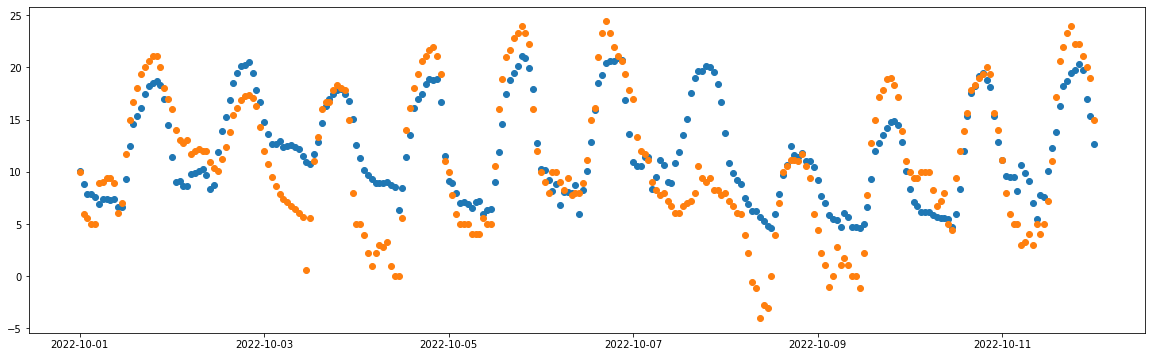

In [16]:
x= xt_predict.loc['2022-10-01 0:00:00':'2022-10-12 00:00:00'].index
y= xt_predict.loc['2022-10-01 0:00:00':'2022-10-12 00:00:00']['temp']
y2 = xt_predict.loc['2022-10-01 0:00:00':'2022-10-12 00:00:00']['tempactual']
figure(figsize=(20,6))
plt.scatter(x,y)
plt.scatter(x,y2)
plt.show()

### Random Fit 

In [98]:

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 11)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 1000, num = 20)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 40]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 290, 480, 670, 860, 1050, 1240, 1430, 1620, 1810, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 62, 114, 166, 218, 270, 322, 374, 426, 478, 531, 583, 635, 687, 739, 791, 843, 895, 947, 1000, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [102]:
xt_reg = ExtraTreesRegressor()
rf_random = RandomizedSearchCV(estimator = xt_reg, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=2, random_state=42, n_jobs = -1)
#rf_random.fit(X_train,y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


C:\Users\paull\Anaconda32\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\paull\Anaconda32\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\paull\Anaconda32\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\paull\Anaconda32\lib\site-packages\joblib\parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\paull\Anaconda32\lib\site-pac

RandomizedSearchCV(cv=2, estimator=ExtraTreesRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 62, 114, 166, 218,
                                                      270, 322, 374, 426, 478,
                                                      531, 583, 635, 687, 739,
                                                      791, 843, 895, 947, 1000,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 290, 480, 670,
                                                         860, 1050, 1240, 1430,
                                                         1620, 1810, 2000]},
                   rand

In [103]:
rf_random.best_params_

{'n_estimators': 1430,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [91]:
space  = [Integer(100,200, name='n_estimators'),
          #Integer(1, 10000000, name='max_depth'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    xt_reg.set_params(**params)

    return -xt_reg.fit(X_train,y_train).score(X_test,y_test)

res_gp = gp_minimize(objective, space, n_calls=100, random_state=696)

print(f"Best score: {res_gp.fun}")
print("Best parameters:")
print(f" - n_estimators= {res_gp.x[0]}")
#print(f" - max_depth= {res_gp.x[1]}")
print(f" - min_samples_split= {res_gp.x[1]}")
print(f" - min_samples_leaf=  {res_gp.x[2]}")

C:\Users\paull\Anaconda32\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\paull\Anaconda32\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\paull\Anaconda32\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best score: -0.06170676092098093
Best parameters:
 - n_estimators= 110
 - min_samples_split= 99
 - min_samples_leaf=  4


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

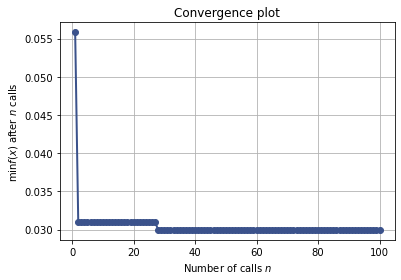

In [89]:
plot_convergence(res_gp)

In [66]:
lasso_reg = linear_model.Lasso(alpha=0.1,max_iter=1500)
b=lasso_reg.fit(X_train,y_train)
b.score(X_test,y_test)


0.6867017440751064

In [67]:
tw_reg = linear_model.TweedieRegressor(max_iter=10800)
c=tw_reg.fit(X_train,y_train)
c.score(X_test,y_test)

0.6877896737418978

In [60]:
feature_importance_df = pd.DataFrame([X.columns, xt_reg.feature_importances_]).transpose()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.sort_values('Importance',ascending=False,inplace=True)
feature_importance_df

,Feature,Importance
10,ATAhr-temp,0.186345
17,L5Ahr-temp,0.137142
0,temp,0.119906
31,L5Aday-temp,0.10293
24,ATAday-temp,0.09532
32,L5Aday-dwpt,0.067723
11,ATAhr-dwpt,0.058658
25,ATAday-dwpt,0.051312
18,L5Ahr-dwpt,0.024241
7,DayOfYear,0.015974


In [15]:
X_cols = [col for col in df.columns if "~" not in col]
X = df[X_cols]
y = df['24hr~temp']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=696)
xt_reg = ExtraTreesRegressor(random_state=696,n_jobs=-1)
lasso_reg = linear_model.Lasso(alpha=0.1,max_iter=1500)
tw_reg = linear_model.TweedieRegressor(max_iter=500)
dummy_reg = DummyRegressor(strategy="median")
models = {'Extra Trees Regressor':xt_reg,
          'Lasso Regressor':lasso_reg,
          'Tweedie Regressor':tw_reg,
          'Dummy Regressor':dummy_reg}
for key, value in models.items():
    cv_results = cross_validate(value, X_train, y_train, cv=5,n_jobs=-1)
    print(key)
    print("Mean accuracy score: ", end="")
    print(round(cv_results['test_score'].mean(),3), end="")
    print(", best accuracy score: ", end="")
    print(round(cv_results['test_score'].max(),3), end="")
    print(", with std dev of: ", end="")
    print(round(cv_results['test_score'].std(),3))
    print("Mean training time: ", end="")
    print(round(cv_results['score_time'].mean(),3))
    print(f"Score on hold out set: {round(value.fit(X_train, y_train).score(X_test, y_test),3)}")
    print("**************")

Extra Trees Regressor
Mean accuracy score: 0.939, best accuracy score: 0.94, with std dev of: 0.001
Mean training time: 0.656
Score on hold out set: 0.946
**************
Lasso Regressor
Mean accuracy score: 0.87, best accuracy score: 0.872, with std dev of: 0.001
Mean training time: 0.003
Score on hold out set: 0.873
**************
Tweedie Regressor
Mean accuracy score: 0.868, best accuracy score: 0.871, with std dev of: 0.001
Mean training time: 0.006


c:\users\jesse\onedrive\documents\homework\mich\521\ms2_git\lib\site-packages\sklearn\linear_model\_glm\glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Score on hold out set: 0.871
**************
Dummy Regressor
Mean accuracy score: -0.001, best accuracy score: -0.0, with std dev of: 0.001
Mean training time: 0.002
Score on hold out set: -0.0
**************


### Examine the feature importances in the best performing model (Extra Trees Regressor)

In [16]:
feature_importance_df = pd.DataFrame([X.columns, xt_reg.feature_importances_]).transpose()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.sort_values('Importance',ascending=False,inplace=True)
feature_importance_df

,Feature,Importance
10,ATAhr-temp,0.250468
0,temp,0.194401
17,L5Ahr-temp,0.12466
24,ATAday-temp,0.088224
31,L5Aday-temp,0.04911
32,L5Aday-dwpt,0.035966
25,ATAday-dwpt,0.035249
11,ATAhr-dwpt,0.034425
1,dwpt,0.034257
18,L5Ahr-dwpt,0.024618


In [17]:
alt.Chart(feature_importance_df[:5]).mark_bar().encode(
    x=alt.X('Importance:Q', axis=alt.Axis(format="%", tickSize=0, labelFontSize=12)),
    y=alt.Y(
        'Feature:N', sort=list(feature_importance_df[:5].Feature), title="",
        axis=alt.Axis(tickSize=0, labelFontSize=12, labelPadding=10)),
).properties(
    height=200
)

alt.Chart(...)

### Hyper-parameter tuning the Extra Trees Regressor with the expanded dataset
5 fold cross validate looking for the optimized estimators, depth, sample split, and sample leaf parameters. Evaluating the 'best' based on the mean squared error achieved.

In [18]:
space  = [Integer(100,200, name='n_estimators'),
          Integer(1, 50, name='max_depth'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    xt_reg.set_params(**params)

    return -np.mean(cross_val_score(xt_reg, X_train, y_train, cv=5, n_jobs=-1))

res_gp = gp_minimize(objective, space, n_calls=15, random_state=696)

print(f"Best score: {res_gp.fun}")
print("Best parameters:")
print(f" - n-estimators= {res_gp.x[0]}")
print(f" - max_depth= {res_gp.x[1]}")
print(f" - min_samples_split= {res_gp.x[2]}")
print(f" - min_samples_leaf=  {res_gp.x[3]}")

Best score: -0.9398753621255287
Best parameters:
 - n-estimators= 200
 - max_depth= 36
 - min_samples_split= 2
 - min_samples_leaf=  1


### Plot the convergence of the hyperparameter tuning

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

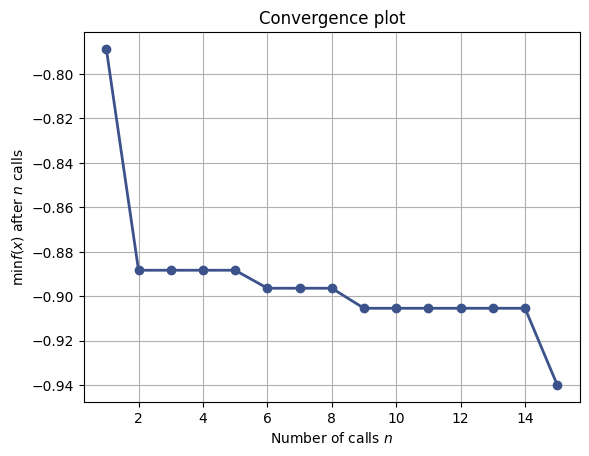

In [19]:
plot_convergence(res_gp)

### Re-train the model with the tuned hyper-parameters
Again, only marginal accuracy improvemens achieved with the tuned parameters

In [20]:
xt_reg = ExtraTreesRegressor(n_estimators=res_gp.x[0], 
                             max_depth=res_gp.x[1], 
                             min_samples_split=res_gp.x[2], 
                             min_samples_leaf=res_gp.x[3], 
                             random_state=696,n_jobs=-1
                            )
models = {'Extra Trees Regressor':xt_reg}
for key, value in models.items():
    cv_results = cross_validate(value, X_train, y_train, cv=5,n_jobs=-1)
    print(key)
    print("Mean accuracy score: ", end="")
    print(round(cv_results['test_score'].mean(),3), end="")
    print(", best accuracy score: ", end="")
    print(round(cv_results['test_score'].max(),3), end="")
    print(", with std dev of: ", end="")
    print(round(cv_results['test_score'].std(),3))
    print("Mean training time: ", end="")
    print(round(cv_results['score_time'].mean(),3))
    print(f"Score on hold out set: {round(value.fit(X_train, y_train).score(X_test, y_test),3)}")
    print("**************")

Extra Trees Regressor
Mean accuracy score: 0.94, best accuracy score: 0.941, with std dev of: 0.001
Mean training time: 1.035
Score on hold out set: 0.946
**************


# UNFINISHED WORK

In [21]:
pred_df = pd.DataFrame()
pred_df['Actual'] = y.values
pred_df['XT-pred'] = xt_reg.predict(X)
# pred_df['Lo-pred'] = lasso_reg.predict(X)
# pred_df['Tw-pred'] = tw_reg.predict(X)
# pred_df['Dum-pred'] = dummy_reg.predict(X)
pred_df['TimeStamp'] = df.index
pred_df = pred_df.melt(id_vars='TimeStamp')
pred_df = pred_df[pred_df['TimeStamp'].dt.year == 2022]
pred_df = pred_df[pred_df['TimeStamp'].dt.month == 8]

In [22]:
alt.data_transformers.disable_max_rows()
alt.Chart(pred_df).mark_line().encode(
    x=alt.X('TimeStamp:T', axis=alt.Axis(tickSize=0, labelFontSize=12)),
    y=alt.Y('value:Q'),
    color='variable',
    strokeDash='variable',
    row=alt.Row('variable:N')
).properties(
    height=100,
    width=600
)

alt.Chart(...)